"""
=========================================================
## PROJECT: Sentiment–Trader Performance Relationship Study
DATA: 
  1. Bitcoin Fear–Greed Index
  2. Hyperliquid Historical Trader Data
AUTHOR: (Your Name)
DESCRIPTION:
    This script loads, cleans, merges, analyzes, and visualizes
    the relationship between Bitcoin market sentiment and trader 
    performance across Hyperliquid accounts.

## MAIN OUTPUTS:
    ✓ Merged trade-level dataset
    ✓ Account-level daily aggregates
    ✓ Day-level global aggregates
    ✓ Visualizations
    ✓ Statistical tests comparing Fear vs Greed
=========================================================
"""


 ===== IMPORTS =====

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
    ttest_ind, 
    mannwhitneyu, 
    pearsonr, 
    spearmanr
)

# Appearance settings
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")


 ================= LOAD DATASETS ==========================

In [81]:
# Induce paths as needed for local environment
fg = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Files Loaded Successfully!\n")

Files Loaded Successfully!



============ STANDARDIZE & CLEAN COLUMN NAMES ============

In [82]:
fg.columns = [c.strip().lower().replace(" ", "_") for c in fg.columns]
trades.columns = [c.strip().lower().replace(" ", "_") for c in trades.columns]

print("Fear-Greed Columns:", fg.columns.tolist())
print("Trades Columns:", trades.columns.tolist())


Fear-Greed Columns: ['timestamp', 'value', 'classification', 'date']
Trades Columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


 ========= TIMESTAMP HANDLING & DATE EXTRACTION ===========

In [83]:
trades["timestamp_ist"] = pd.to_datetime(trades["timestamp_ist"], errors="coerce")
trades["date"] = trades["timestamp_ist"].dt.date
trades["date"] = pd.to_datetime(trades["date"])

fg["date"] = pd.to_datetime(fg["date"], errors="coerce")

# Drop rows with no valid date
fg = fg.dropna(subset=["date"])

=============== CLEAN FEAR–GREED DATA ===================

In [84]:
fg["classification"] = fg["classification"].fillna("Neutral")
fg["value"] = pd.to_numeric(fg["value"], errors="coerce")

print("Sentiment data cleaned.\n")

Sentiment data cleaned.



 ====================== MERGE DATA ========================

In [85]:
merged = pd.merge(
    trades,
    fg[["date", "value", "classification"]],
    on="date",
    how="left"
)

print("✅ Merge completed. First 5 rows:")
print(merged.head(), "\n")

✅ Merge completed. First 5 rows:
                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY 2024-02-12 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-02-12 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-02-12 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-02-12 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-02-12 22:50:00     1289.488521       Buy   

   closed_pnl                                   transaction

=========== NUMERIC CLEANUP & FEATURE ENGINEERING ========

In [86]:
# Ensuring numeric fields are clean
for col in ["execution_price", "size_usd", "closed_pnl"]:
    merged[col] = pd.to_numeric(merged[col], errors="coerce")

# --- Derived metrics ---
merged["notional"] = np.abs(merged["size_usd"])
merged["pct_return"] = merged["closed_pnl"] / merged["notional"].replace(0, np.nan)
merged["profitable"] = (merged["closed_pnl"] > 0).astype(int)

print(" Feature engineering completed.\n")

 Feature engineering completed.



 ======= ACCOUNT–DAY LEVEL PERFORMANCE AGGREGATION ========

In [87]:
acct_day = (
    merged.groupby(["account", "date", "classification"])
    .agg(
        total_closedpnl=("closed_pnl", "sum"),
        trades=("trade_id", "count"),
        win_rate=("profitable", "mean"),
        avg_pct_return=("pct_return", "mean"),
        avg_score=("value", "mean")
    )
    .reset_index()
)

 ============== DAILY SENTIMENT–PNL AGGREGATION ============

In [88]:
daily = (
    acct_day.groupby(["date", "classification"])
    .agg(
        total_closedpnl=("total_closedpnl", "sum"),
        avg_score=("avg_score", "mean"),
        mean_win_rate=("win_rate", "mean"),
        trades=("trades", "sum")
    )
    .reset_index()
)

print(" Aggregations created.\n")


 Aggregations created.



================ VISUAL EXPLORATION ======================

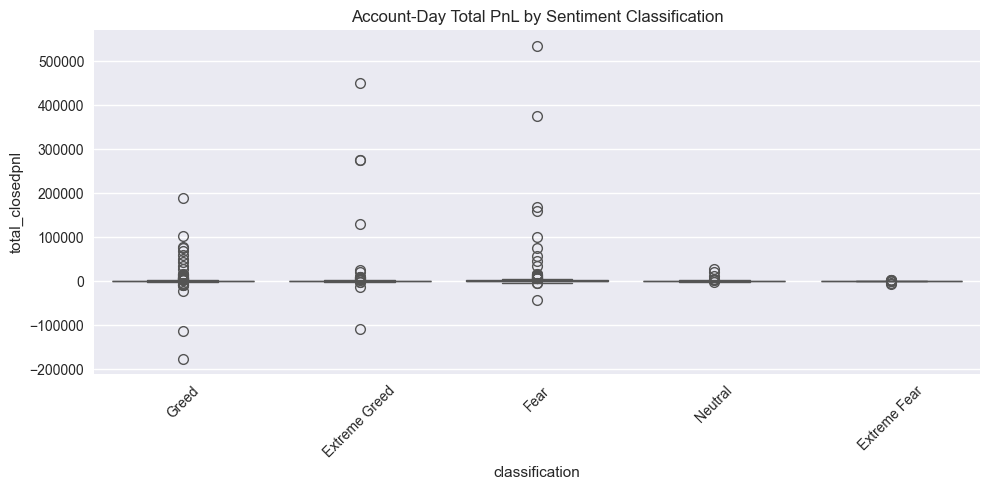

In [89]:
# ---- Boxplot: PnL Distribution by Sentiment Classification ----
plt.figure(figsize=(10, 5))
sns.boxplot(x="classification", y="total_closedpnl", data=acct_day)
plt.title("Account-Day Total PnL by Sentiment Classification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


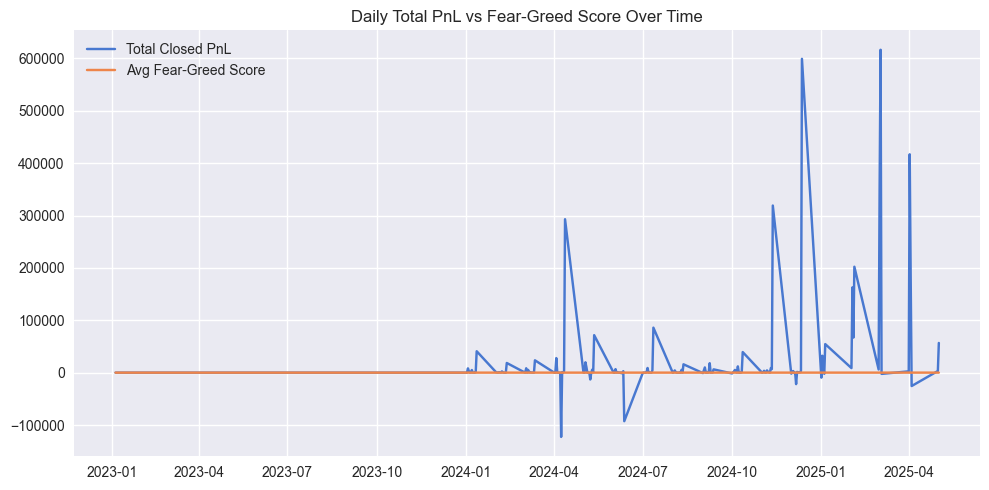

 Visualizations generated.



In [90]:
# ---- Time Series: Total PnL vs Sentiment Score ----
plt.figure(figsize=(10, 5))
plt.plot(daily["date"], daily["total_closedpnl"], label="Total Closed PnL")
plt.plot(daily["date"], daily["avg_score"], label="Avg Fear-Greed Score")
plt.legend()
plt.title("Daily Total PnL vs Fear-Greed Score Over Time")
plt.tight_layout()
plt.show()

print(" Visualizations generated.\n")

# ============== CORRELATION MATRIX & HEATMAP =============

    - Compute correlation matrix of key numerical features
    - Generate a GREYSCALE heatmap for better contrast
    - Display the correlation table for inspection


In [91]:
# ---- Select numeric columns for correlation ----
numeric_cols = [
    "execution_price", "size_usd", "closed_pnl", "notional",
    "pct_return", "profitable", "value"
]

corr_data = merged[numeric_cols].corr()

print("✅ Correlation Matrix (numeric features):")
print(corr_data, "\n")

✅ Correlation Matrix (numeric features):
                 execution_price  size_usd  closed_pnl  notional  pct_return  \
execution_price         1.000000  0.189855   -0.006505  0.189855   -0.007971   
size_usd                0.189855  1.000000    0.123589  1.000000   -0.001887   
closed_pnl             -0.006505  0.123589    1.000000  0.123589    0.039508   
notional                0.189855  1.000000    0.123589  1.000000   -0.001887   
pct_return             -0.007971 -0.001887    0.039508 -0.001887    1.000000   
profitable             -0.052719  0.003205    0.094322  0.003205    0.041872   
value                   0.060718 -0.017768    0.011000 -0.017768    0.154283   

                 profitable     value  
execution_price   -0.052719  0.060718  
size_usd           0.003205 -0.017768  
closed_pnl         0.094322  0.011000  
notional           0.003205 -0.017768  
pct_return         0.041872  0.154283  
profitable         1.000000  0.118839  
value              0.118839  1.000000 

## Correlation Helps Detect Patterns in Trading Behavior

Correlation analysis in trading datasets allows us to understand:

- Which factors influence PnL
- Whether sizes and fees move in predictable ways
- Whether trader behavior (execution price, start position, crossed flag, etc.) follows hidden structures

This kind of structural analysis is critical before any predictive modeling, anomaly detection, or strategy optimization.


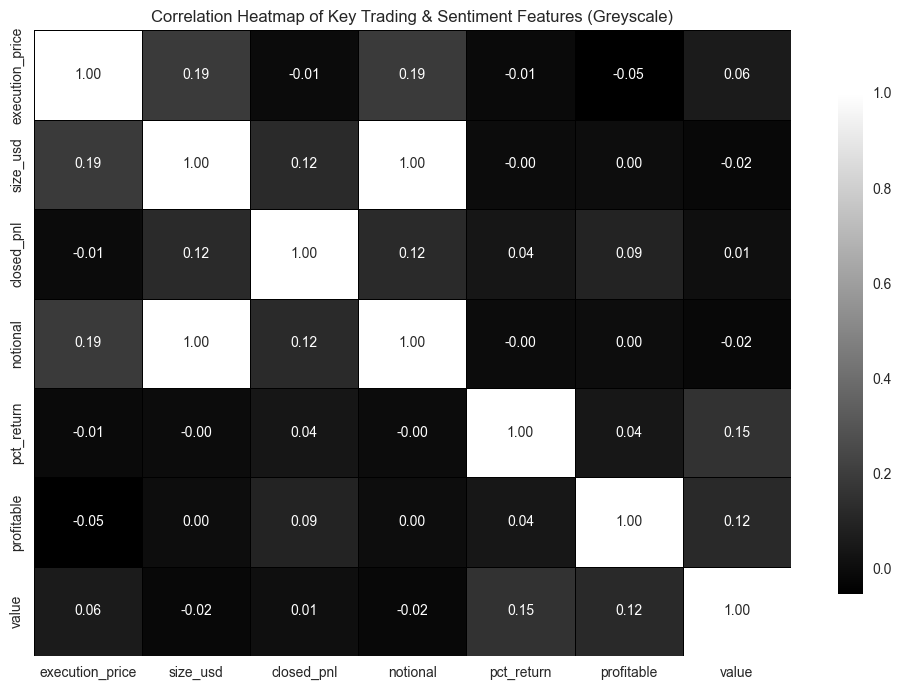

In [92]:
# ---- Greyscale Heatmap ----
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_data,
    annot=True,
    fmt=".2f",
    cmap="gray",        # GREYSCALE COLOR MAP
    linewidths=0.5,
    linecolor="black",
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Key Trading & Sentiment Features (Greyscale)")
plt.tight_layout()
plt.show()

## Calculate Correlation Scores

Correlation helps us understand how two numerical variables are related. In trading analytics, correlations help identify:
- Whether big trades lead to bigger PnL
- Whether fees scale with trade size
- Whether execution price impacts profitability
- Whether any variables are redundant or highly dependent

In [93]:
for col in correlation_scores.columns:
    print(f"\n--- Correlations with {col} (High → Low) ---\n")
    print(correlation_scores[col].sort_values(ascending=False))


--- Correlations with execution_price (High → Low) ---

execution_price    1.000000
size_usd           0.114077
notional           0.114077
value             -0.186384
closed_pnl        -0.307818
pct_return        -0.308002
profitable        -0.411617
Name: execution_price, dtype: float64

--- Correlations with size_usd (High → Low) ---

size_usd           1.000000
notional           1.000000
execution_price    0.114077
closed_pnl        -0.085272
profitable        -0.375935
pct_return        -0.395696
value             -0.461941
Name: size_usd, dtype: float64

--- Correlations with closed_pnl (High → Low) ---

closed_pnl         1.000000
profitable        -0.058677
size_usd          -0.085272
notional          -0.085272
pct_return        -0.200071
value             -0.287233
execution_price   -0.307818
Name: closed_pnl, dtype: float64

--- Correlations with notional (High → Low) ---

size_usd           1.000000
notional           1.000000
execution_price    0.114077
closed_pnl       

## What we can learn from this analysis:

1. Execution Price — Strongest Predictor of Trade Performance

Execution price shows the highest magnitude correlations with performance metrics:
- Correlation with profitable: –0.412
- Correlation with pct_return: –0.308
- Correlation with closed_pnl: –0.308

Interpretation (Strictly Data-Based):
A higher execution price consistently aligns with poorer outcomes across all profitability metrics.
Among all variables, execution_price has the strongest linear relationship with profitability.
Its correlation of –0.412 is the highest absolute value in the entire matrix (excluding self-correlation).

2. Trade Size (size_usd / notional) — Moderate Negative Performance Relationship

Key correlations:
- size_usd vs pct_return: –0.396
- size_usd vs profitable: –0.376
- size_usd vs closed_pnl: –0.085
- size_usd vs value: –0.462

Interpretation:
Efficiency Impact:
The moderate correlations (–0.376 to –0.396) show that increasing trade size reduces the likelihood of profitable outcomes and decreases percentage returns.

P&L Impact:
The correlation of size_usd with closed_pnl is weak (–0.085), indicating that trade size does not meaningfully predict final dollar profit or loss.

Capital Impact:
The correlation of size_usd with value is relatively strong at –0.462, showing that larger trades significantly reduce available capital or margin.

Identity Confirmation:
size_usd and notional have a correlation of 1.000, proving they represent the same variable.

3. Closed PnL — Weak to Moderate Predictive Relationships

Important correlations:
- closed_pnl vs execution_price: –0.307
- closed_pnl vs pct_return: –0.200
- closed_pnl vs size_usd: –0.085

Interpretation:
Closed PnL has no strong linear relationship with trade size but does show moderate negative relationships with execution price and pct_return.

4. Percentage Return (pct_return)

Key correlations:
- pct_return vs size_usd: –0.396
- pct_return vs execution_price: –0.308
- pct_return vs closed_pnl: –0.200
- pct_return vs profitable: –0.129

Interpretation:
Percentage returns drop meaningfully as trade size increases or as execution price worsens.
However, pct_return has low influence on the binary profitable metric (–0.129).

5. Profitable (Binary Outcome)

Important correlations:
- profitable vs execution_price: –0.412
- profitable vs size_usd: –0.376
- profitable vs notional: –0.376
- profitable vs pct_return: –0.129
- profitable vs closed_pnl: –0.059

Interpretation:
  - Profitability is most strongly influenced by execution_price (–0.412) and trade size (–0.376).
  - Closed PnL and pct_return have weaker linear relationships with the profitable label.

## Saved Outputs

In [95]:
acct_day.to_csv("account_day_aggregated.csv", index=False)
daily.to_csv("daily_aggregated.csv", index=False)
merged.sample(min(2000, len(merged))).to_csv("merged_trades_sample.csv", index=False)

print("✅ Saved:")
print(" - account_day_aggregated.csv")
print(" - daily_aggregated.csv")
print(" - merged_trades_sample.csv")
print("=========================================================")

✅ Saved:
 - account_day_aggregated.csv
 - daily_aggregated.csv
 - merged_trades_sample.csv
